## CS 476 A3 Q4
#### Jeongseop Yi (Patrick), j22yi

#### a)

The value of $B_0 = -\delta_0 S_0 + C_0$. As $\delta_t = 0$ when $S_t < K$ and $S_0 < K$, so we have $B_0 = C_0$

The writer's trading stratgy is:
$$
\delta_t = 
\begin{cases}
    0,  & \text{if } S_t < K\\
    1,  & \text{otherwise}
\end{cases}
$$

#### b)

From the continous trading assumption, the stock is bought or sold at the price $K$ when the price reaches above or drops below K, respectively. As the stock is traded at one price, $B_t$ is always either $C_0 - K$ when $S_t \geq K$ or $C_0$ when $S_t < K$ as $B_0 = C_0$.

With the information above, if $S_t \geq K$, we have $\delta_t = 1$, so the portfolio value is $\delta_t S_t + B_0 = S_t - K + C_0$, and if $S_t < K $, $\delta_t = 0$, so the portfolio value is $\delta_t S_t + B_0 = C_0$

#### c)
There exist two cases: 1. $S_T \geq K$ and 2. $S_T < K$.

If $S_T \geq K$:

$$ 
\begin{align*}
-C_T + \delta_T S_T + B_T &= K - S_T + S_T - K + C_0 \\
&= C_0
\end{align*}
$$

If $S_T < K$:

$$ 
\begin{align*}
-C_T + \delta_T S_T + B_T &= 0 + 0 + C_0 \\
&= C_0
\end{align*}
$$

In both cases, the value of P&L are the same, which equals to C_0.
Therefore, the value of relative P&L is 1, and also the mean of the relative P&L is 1.
As the relative P&L value does not change for any $S_T$, the variance of the relative P&L is 0.

#### d)

In [26]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
def blsprice2(S0, K, r, T, sigma):
    ''' Valuation of European option in BSM model Analytical formula.
    '''
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # if optionType == 'call':
    C_value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) -
               K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    # elif optionType == 'put':
    P_value = (K * np.exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0)
               - S0 * stats.norm.cdf(-d1, 0.0, 1.0))
    return (C_value, P_value)

# define functions for Monte Carlo simulation
def MC_simulation(S0, mu, sigma, T, M, N):
    Dt = T / N
    S = np.zeros((N+1, M))
    S[0, :] = S0
    for i in range(1, N + 1):
        S[i, :] = S[i-1, :] * \
                  np.exp((mu - sigma ** 2 / 2)
                         * Dt + sigma*np.sqrt(Dt)*np.random.normal(0, 1, M))
    return S

# hedging strategy
def hedging_delta(S, K):
    if (S > K):
        return 1
    else:
        return 0

def call_payoff(S, K):
    return np.max(S - K, 0)

def MC_VAR(S0, mu, sigma, T, M, C0, K, N):
    S = MC_simulation(S0, mu, sigma, T, M, N)
    VN = list(map(lambda x: call_payoff(x, K), S[N]))
    B = C0 * np.ones(M)

    for n in range(1, N):
        Sn = S[n-1]
        Sn1 = S[n]
        dn = np.array(list(map(lambda x: hedging_delta(x, K), Sn)))
        dn1 = np.array(list(map(lambda x: hedging_delta(x, K), Sn1)))
        B = B + (dn - dn1) * Sn1

    PNL = B + S[N]*list(map(lambda x: hedging_delta(x, K), S[N-1])) - VN
    return PNL / C0

def dVarCVar(PNL, beta):
    PNL = np.sort(PNL)
    N = len(PNL)
    dVar = PNL[int((1-beta)*N)]
    cVar = np.mean(PNL[PNL < dVar])
    return (dVar, cVar)


The function `hedging_strat` is to denote the change of the hedging position given the stock price, current position, and strike price.
The function `hedging_cost` is to calculate the cost of hedging in between the timesteps. The value of the portfolio changes only when the writer held the stock at $t_{k}$ regardless of whether the writer sold stock or not at $t_{k+1}$.

The stock prices are calculated using `MC_simulation` function and the position and value of the hedging portfolio is calculated in `MC_VAR` function.
`MC_VAR` function returns the final value of the hedging portfolios divided by the call option value.
`blsprice2` function is needed to calculate the actual call option value from BS model.

In [28]:
# table 1 value
sigma = .20
mu = 0.15
T = 1 
S0 = 95
K = 105
C0 = blsprice2(S0, K, 0, sigma, T)[0]

# Run Monte Carlo simulation with 100, 200, 400, and 800 steps
MC_100 = MC_VAR(S0, mu, sigma, T, 80000, C0, K, 100)
MC_200 = MC_VAR(S0, mu, sigma, T, 80000, C0, K, 200)
MC_400 = MC_VAR(S0, mu, sigma, T, 80000, C0, K, 400)
MC_800 = MC_VAR(S0, mu, sigma, T, 80000, C0, K, 800)

# create dataframe for nice table output for simulation results
MC_df = pd.DataFrame(columns=['100', '200', '400', '800'])
MC_df.loc['mean'] = [np.mean(MC_100), np.mean(MC_200), np.mean(MC_400), np.mean(MC_800)]
MC_df.loc['std'] = [np.std(MC_100), np.std(MC_200), np.std(MC_400), np.std(MC_800)]
MC_df.loc['VaR'] = [dVarCVar(MC_100, 0.95)[0], dVarCVar(MC_200, 0.95)[0], 
                    dVarCVar(MC_400, 0.95)[0], dVarCVar(MC_800, 0.95)[0]]
MC_df.loc['CVaR'] = [dVarCVar(MC_100, 0.95)[1], dVarCVar(MC_200, 0.95)[1], 
                     dVarCVar(MC_400, 0.95)[1], dVarCVar(MC_800, 0.95)[1]]


,100,200,400,800
mean,1.069377,1.071660,1.077684,1.080710
std,0.954516,0.957075,0.956751,0.956423
VaR,-0.147950,-0.145482,-0.142228,-0.134837
CVaR,-0.445064,-0.446738,-0.438721,-0.434447


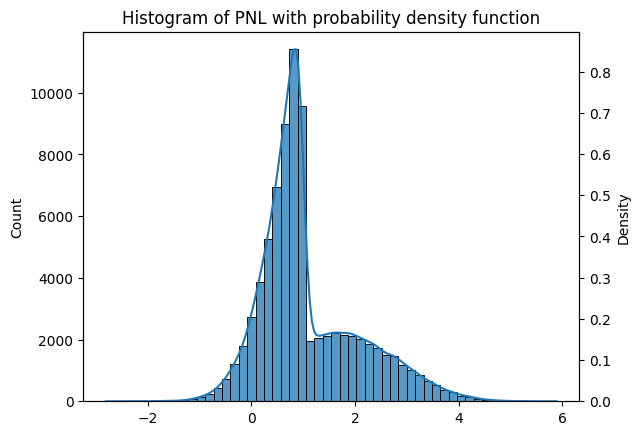

In [29]:
# show table of simulation results
display(MC_df)

# plot histogram of P&L for 800 steps
ax = sns.histplot(MC_800, bins=50, legend=False)
sns.kdeplot(data=MC_800, ax=ax.twinx(), legend=True)
plt.title('Histogram of PNL with probability density function')
plt.xlabel('Relative P&L from MC simulation with 800 steps')
plt.show()

The mean of the hedging error is fairly lose to 1 for all MC simulations which is close to the mean of the relative P&L discussed in c). 
The small minor error may derive from the time discretization error, which will be discussed in e).

However, the volatility is not 0 for all MC simulations different from the theoretical volatility from c). This error also may derive from the time discretization error, which is discussed in e).

#### e)

The discrepancy in the variance between the MC simulation and the theoretical value under the continuous hedging assumption is due to the time discretization error. In MC simulations, time is discretized, and the portfolio cannot be rebalanced right away when the stock price hits the strike price $K$ but rebalanced at the stock price at each timestep. However, in the continous trading assumption, the portfolio can be rebalanced right away when the stock price hits the strike price $K$, leading to 0 variance.